In [41]:
import torch
import torch.nn.functional as F
import numpy as np
import math
from typing import List, Tuple, Dict



# Define the Laplacian kernel at the module level for efficiency.
# It's a 5-point stencil for a 2D grid.
_LAPLACIAN_KERNEL = torch.tensor([[0., 1., 0.], [1., -4., 1.], [0., 1., 0.]]).view(1, 1, 3, 3)

def _compute_laplacian_2d(grid: torch.Tensor, dx: float) -> torch.Tensor:
    """
    Computes the 2D Laplacian of a grid using a 5-point stencil convolution.
    Handles No-Flux (Neumann) boundary conditions via 'replicate' padding.

    Args:
        grid (torch.Tensor): The input grid of shape [batch_size, N, N].
        dx (float): The spatial step size.

    Returns:
        torch.Tensor: The computed Laplacian of the grid.
    """
    # The kernel must be on the same device as the input grid.
    kernel = _LAPLACIAN_KERNEL.to(grid.device)
    
    # Add a channel dimension for conv2d compatibility: [B, N, N] -> [B, 1, N, N].
    grid_ch = grid.unsqueeze(1)
    
    # Pad the grid by one layer on all sides. 'replicate' mode copies the edge
    # values, which is a standard way to implement Neumann boundary conditions
    # for a finite difference scheme.
    padded_grid = F.pad(grid_ch, (1, 1, 1, 1), mode='replicate')
    
    # Apply the convolution. 'valid' padding means no extra padding is added by the conv layer itself.
    laplacian = F.conv2d(padded_grid, kernel, padding='valid')
    
    # Scale the result by 1/dx^2 and remove the channel dimension to get the final result.
    return laplacian.squeeze(1) / (dx**2)

def _compute_reactions(u: torch.Tensor, v: torch.Tensor, w: torch.Tensor, params: Dict) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Computes the reaction terms (RHS of the ODEs) for the PDE system.
    This function is fully vectorized using PyTorch operations.

    Args:
        u, v, w (torch.Tensor): Current state variables.
        params (Dict): Dictionary of model parameters.

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: The reaction terms for u, v, and w.
    """
    # Heaviside step functions are implemented as boolean masks converted to float (0.0 or 1.0).
    H_uc = (u >= params['V_c']).float()
    H_uv = (u >= params['V_v']).float()

    # Calculate ionic currents as per the model equations.
    I_fi = -v * H_uc * (u - params['V_c']) * (1 - u) / params['tau_d']
    I_so = u * (1 - H_uc) / params['tau_0'] + H_uc / params['tau_r']
    I_si = -w * (1 + torch.tanh(params['k'] * (u - params['V_csi']))) / (2 * params['tau_si'])

    # Total reaction term for u (dudt_reaction). Note: the PDE has a minus sign before this term.
    dudt_reaction = (I_fi + I_so + I_si) / params['C_m']

    # Gating variable v's time constant (tau_mv) is dependent on u.
    tau_mv = (1.0 - H_uv) * params['tau_v1'] + H_uv * params['tau_v2']

    # dv/dt is computed using torch.where for conditional logic based on u.
    dvdt = torch.where(
        u < params['V_c'],
        (1.0 - v) / tau_mv,
        -v / params['tau_pv']
    )

    # dw/dt is also computed using torch.where for its conditional logic.
    dwdt = torch.where(
        u < params['V_c'],
        (1.0 - w) / params['tau_mw'],
        -w / params['tau_pw']
    )

    return dudt_reaction, dvdt, dwdt

def solver(u_init: np.ndarray, 
           v_init: np.ndarray, 
           w_init: np.ndarray, 
           fk_taud: float, 
           t_eval: List[float]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Solves the 2D reaction-diffusion system for a batch of initial conditions
    using the Forward Euler method on a GPU-accelerated backend.

    Args:
        u_init (np.ndarray): Initial conditions for u, shape [batch_size, N, N].
        v_init (np.ndarray): Initial conditions for v, shape [batch_size, N, N].
        w_init (np.ndarray): Initial conditions for w, shape [batch_size, N, N].
        fk_taud (float): Model parameter tau_d.
        t_eval (List[float]): A list of time points at which to evaluate and return the solution.

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing the solutions
        for u, v, and w at the specified time points (including t=0). Each tensor has a
        shape of [batch_size, len(t_eval) + 1, N, N].
    """
    # 1. Setup device and parameters
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    params = {
        'diffCoef': 0.001, 'C_m': 1.0, 'tau_pv': 7.99, 'tau_v1': 9.8,
        'tau_v2': 312.5, 'tau_pw': 870.0, 'tau_mw': 41.0, 'tau_d': fk_taud,
        'tau_0': 12.5, 'tau_r': 33.83, 'tau_si': 29.0, 'k': 10.0,
        'V_csi': 0.861, 'V_c': 0.13, 'V_v': 0.04
    }

    # 2. Discretization setup
    if u_init.shape[1] != u_init.shape[2]:
        raise ValueError("Spatial domain must be square (N x N).")
    N = u_init.shape[1]
    domain_size = 20.0  # Domain is [-10, 10], so total width/height is 20.0
    dx = domain_size / (N - 1)

    # Choose a small, fixed time step `dt` for the Forward Euler method.
    # A conservative value is chosen to maintain stability, which is often
    # dictated by the fastest reaction dynamics in such systems.
    dt = 0.001
    print(f"Spatial step dx = {dx:.4f}, Time step dt = {dt:.4f}")

    # 3. Initialization
    # Convert numpy inputs to torch tensors, set data type, and move to the selected device.
    u = torch.from_numpy(u_init).float().to(device)
    v = torch.from_numpy(v_init).float().to(device)
    w = torch.from_numpy(w_init).float().to(device)

    # Ensure t_eval is sorted to process time points chronologically.
    t_eval_sorted = sorted(t_eval)
    
    # Store results in lists. Start with the initial state (t=0).
    # We clone and move to CPU to prevent GPU memory accumulation and modification of stored states.
    u_all = [u.cpu().clone()]
    v_all = [v.cpu().clone()]
    w_all = [w.cpu().clone()]

    # 4. Main time-stepping loop
    current_t = 0.0
    
    for i, target_t in enumerate(t_eval_sorted):
        # Ensure we don't simulate backwards if target_t is less than current_t
        if target_t > current_t:
            # Calculate the number of steps required to reach the next evaluation time.
            num_steps = math.ceil((target_t - current_t) / dt)
            
            for _ in range(num_steps):
                # Calculate the diffusion term (Laplacian) for u.
                lap_u = _compute_laplacian_2d(u, dx)
                dudt_diffusion = params['diffCoef'] * lap_u
                
                # Calculate the reaction terms for all three variables.
                dudt_reaction, dvdt, dwdt = _compute_reactions(u, v, w, params)
                
                # Perform the Forward Euler update step for each variable.
                # Note the minus sign for dudt_reaction, as specified in the PDE.
                u = u + dt * (dudt_diffusion - dudt_reaction)
                v = v + dt * dvdt
                w = w + dt * dwdt
            
            # Update the simulation time to reflect the steps taken.
            current_t += num_steps * dt
        
        print(f"Reached evaluation time point {target_t} at simulation time {current_t:.2f} (step {i+1}/{len(t_eval_sorted)})")

        # Store the computed state at the current time point.
        u_all.append(u.cpu().clone())
        v_all.append(v.cpu().clone())
        w_all.append(w.cpu().clone())

    # 5. Output formatting
    # Stack the list of tensors along a new time dimension (dim=1).
    # The output shape will be [batch_size, len(t_eval) + 1, N, N].
    # Note: The requested output shape [..., N] in the prompt is assumed to be a typo
    # for a 2D problem, so [..., N, N] is produced.
    u_out = torch.stack(u_all, dim=1)
    v_out = torch.stack(v_all, dim=1)
    w_out = torch.stack(w_all, dim=1)
    
    print("Solver finished.")

    return u_out, v_out, w_out

[0.0, 9.950000000000045, 19.950000000000045, 29.950000000000045, 39.950000000000045, 49.950000000000045, 59.950000000000045, 69.95000000000005, 79.95000000000005, 89.95000000000005, 99.95000000000005]


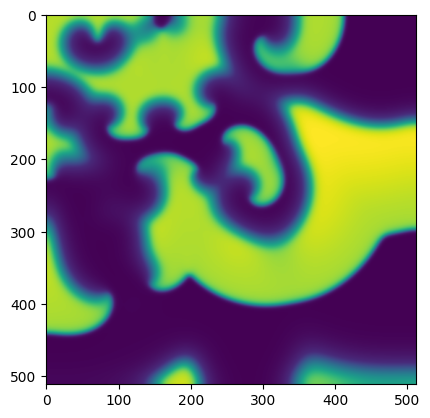

In [42]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt

fk_taud = 0.5714
t_eval = []
folder_path = f'../fk_data/tau_d_{fk_taud}/'
data_path = os.path.join(folder_path, 'UVW_array_data.npz')
data = np.load(data_path)

# Access the arrays
U_init = data['U'][0:1]
V_init = data['V'][0:1]
W_init = data['W'][0:1]

all_files = os.listdir(folder_path)
time = []
for f in all_files:
    if f.startswith('sim_data_') and f.endswith('.csv'):
        match = re.findall(r"[-+]?\d*\.\d+|\d+", f)
        if match:
            time.append(float(match[0]))
time.sort()

time = [t - min(time) for t in time] 

print(time)
# plot U
plt.imshow(U_init[0])

In [43]:
u_out, v_out, w_out = solver(U_init, V_init, W_init, fk_taud, t_eval=time)

Using device: cuda
Spatial step dx = 0.0391, Time step dt = 0.0010
Reached evaluation time point 0.0 at simulation time 0.00 (step 1/11)
Reached evaluation time point 9.950000000000045 at simulation time 9.95 (step 2/11)
Reached evaluation time point 19.950000000000045 at simulation time 19.95 (step 3/11)
Reached evaluation time point 29.950000000000045 at simulation time 29.95 (step 4/11)
Reached evaluation time point 39.950000000000045 at simulation time 39.95 (step 5/11)
Reached evaluation time point 49.950000000000045 at simulation time 49.95 (step 6/11)
Reached evaluation time point 59.950000000000045 at simulation time 59.95 (step 7/11)
Reached evaluation time point 69.95000000000005 at simulation time 69.95 (step 8/11)
Reached evaluation time point 79.95000000000005 at simulation time 79.95 (step 9/11)
Reached evaluation time point 89.95000000000005 at simulation time 89.95 (step 10/11)
Reached evaluation time point 99.95000000000005 at simulation time 99.95 (step 11/11)
Solver 

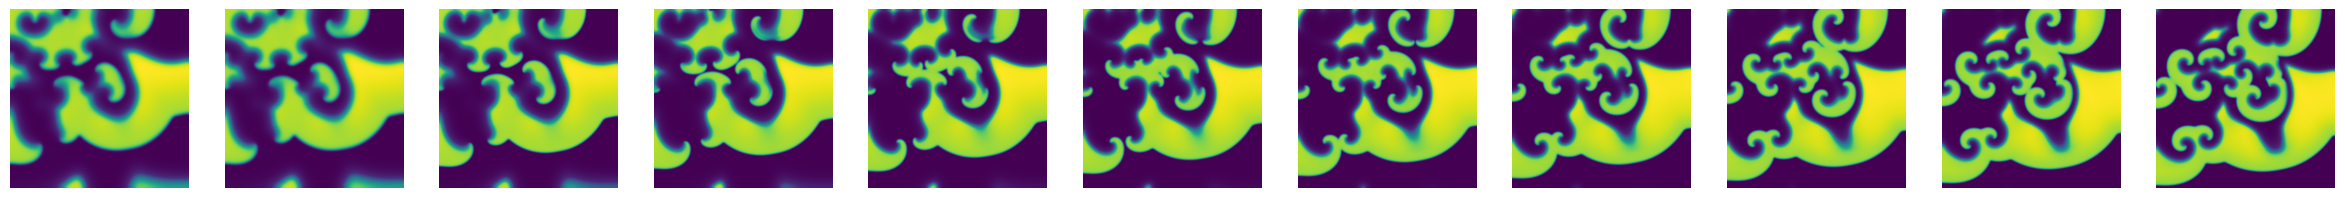

In [44]:
fig, axes = plt.subplots(1, len(time), figsize=(30, 10))
# show all time figure, retain prev time figure
for t in range(len(time)):
    axes[t].imshow(u_out[0, t])
    axes[t].axis('off')

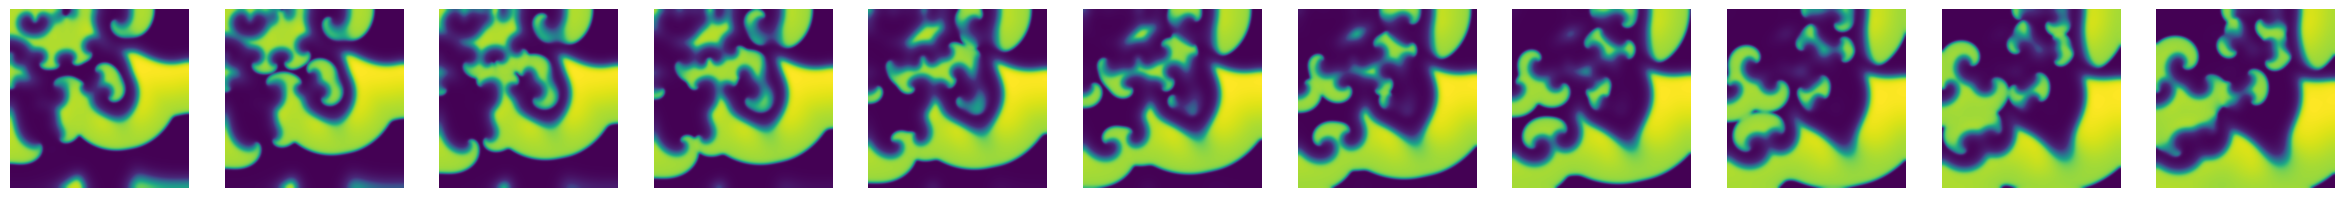

In [45]:
fig, axes = plt.subplots(1, len(time), figsize=(30, 10))
# show all time figure, retain prev time figure
for t in range(len(time)):
    axes[t].imshow(data['U'][t])
    axes[t].axis('off')